In [1]:
import os
import sys

from sklearn.metrics import r2_score
ecpy_path = '../../../ecpy/'
sys.path.insert(0, os.path.abspath(ecpy_path))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import umap

In [2]:
dffrac_pro = pd.read_csv('../Results/protein_abundance_go_slim_level_uniq_asc.csv', index_col=0)

dffrac_mRNA = pd.read_excel('../proteomics/mRNA_abundance_go_slim-20201124.xlsx', sheet_name='mRNA', index_col=0,
                            header=0)
dftot = pd.read_csv('../proteomics/total_protein_abandance_mean.csv', index_col=0)

/cephyr/users/gangl/Vera/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/cephyr/users/gangl/Vera/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/cephyr/users/gangl/Vera/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/cephyr/users/gangl/Vera/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


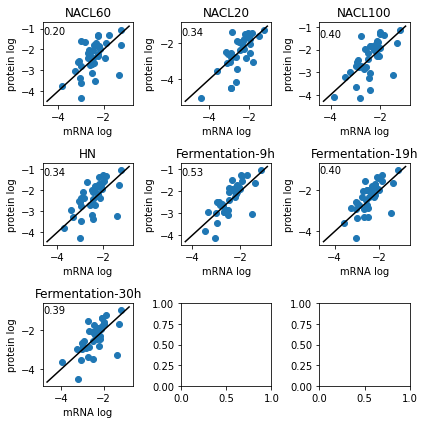

In [3]:
# dffrac_pro
# dffrac_mRNA

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
lim = [-1, 9]

for i, cond_id in enumerate(dftot.index):
    if cond_id == 'MU':
        continue
    ax_i = axs[i // 3, i % 3]
    x_i = np.log10(dffrac_mRNA['MassFrac_' + cond_id])
    y_i = np.log10(dffrac_pro['MassFrac_' + cond_id])
    ax_i.scatter(x_i, y_i)
    # r2_score(x_i.values, y_i.values)
    lim = [min(ax_i.get_ylim()[0], ax_i.get_xlim()[0]), max(ax_i.get_ylim()[1], ax_i.get_xlim()[1])]

    ax_i.plot(lim, lim, 'black')

    y_i_r = y_i.values
    x_i_r = x_i.values
    y_i_r = y_i.values[(y_i.values > -5) & (x_i.values > -5)]
    x_i_r = x_i.values[(y_i.values > -5) & (x_i.values > -5)]
    ax_i.text(ax_i.get_xlim()[0], ax_i.get_ylim()[1] * 1.8, "%.2f" % r2_score(y_i_r, x_i_r))

    ax_i.set_xlabel('mRNA log')
    ax_i.set_ylabel('protein log')
    ax_i.set_title(cond_id)
plt.tight_layout()
plt.show()

coeff_means: 1.651567 
coeff_std: 0.071373


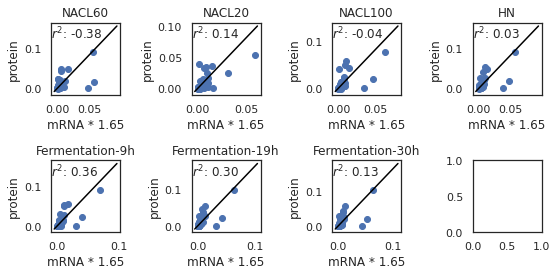

In [57]:
# y = 1.6x —+ stv
# dffrac_mRNA
coeff_dic = {'NACL60': 1.586596438, 'NACL20': 1.572338571, 'NACL100': 1.635750178,
             'HN': 1.702987161, 'Fermentation-9h': 1.6792188,
             'Fermentation-19h': 1.787498847, 'Fermentation-30h': 1.596578543, }

coeff_means = np.mean(list(coeff_dic.values()))
coeff_std = np.std(list(coeff_dic.values()))
print('coeff_means: %f \ncoeff_std: %f' % (coeff_means, coeff_std))

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
lim = [-1, 9]

for i, cond_id in enumerate(dftot.index):
    if cond_id == 'MU':
        continue
    ax_i = axs[i // 4, i % 4]
    x_i = dffrac_mRNA['MassFrac_' + cond_id]
    y_i = dffrac_pro['MassFrac_' + cond_id]
    ax_i.scatter(x_i, y_i)

    lim = np.array([min(ax_i.get_ylim()[0], ax_i.get_xlim()[0]), max(ax_i.get_ylim()[1], ax_i.get_xlim()[1])])

    ax_i.plot(lim, lim * 1.65, 'black')
    ax_i.text(ax_i.get_xlim()[0], ax_i.get_ylim()[1] * 0.75,
              "$r^2$: %.2f" % r2_score( y_i.values,x_i.values * coeff_dic[cond_id]))

    ax_i.set_xlabel('mRNA * 1.65')
    ax_i.set_ylabel('protein')
    ax_i.set_title(cond_id)
plt.tight_layout()
plt.show()

### umap

In [5]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

pro_result_df = pd.read_csv('../Results/FVA_result_df_pro_1204.tsv', sep='\t', index_col=0, )
mRNA_result_df = pd.read_csv('../Results/FVA_result_df_mRNA_1204.tsv', sep='\t', index_col=0, )
pro_result_df.columns = pro_result_df.columns + '_pro'
mRNA_result_df.columns = mRNA_result_df.columns + '_mRNA'

In [6]:
pro_result_df.shape

(4828, 1396)

In [7]:
def upam_draw(result_df):
    result_df.head()

    cond_list = [i.split('_')[1] for i in result_df.columns]

    cond_set = list(set(cond_list))
    cond_dic = {cond_set[i]: i for i in range(len(cond_set))}
    color_list = np.array([sns.color_palette()[cond_dic[i]] for i in cond_list])

    type_list = np.array([i.split('_')[-1] for i in result_df.columns])
    pro_type_list = type_list == 'pro'
    mRNA_type_list = type_list == 'mRNA'

    reducer = umap.UMAP()
    
    data = result_df.values.T
    data = StandardScaler().fit_transform(data)

    embedding = reducer.fit_transform(data)
    embedding.shape

    plt.scatter(
        embedding[pro_type_list, 0],
        embedding[pro_type_list, 1],
        c=color_list[pro_type_list],
        marker='o'
    )

    plt.legend
    plt.scatter(
        embedding[mRNA_type_list, 0],
        embedding[mRNA_type_list, 1],
        c=color_list[mRNA_type_list],
        marker='^'
    )

    plt.legend(['pro', 'mRNA'])
    plt.show()

In [50]:
def pca_draw(result_df):
    result_df.head()

    cond_list = [i.split('_')[1] for i in result_df.columns]

    cond_set = list(set(cond_list))
    cond_dic = {cond_set[i]: i for i in range(len(cond_set))}
    color_list = np.array([sns.color_palette()[cond_dic[i]] for i in cond_list])

    type_list = np.array([i.split('_')[-1] for i in result_df.columns])
    pro_type_list = type_list == 'pro'
    mRNA_type_list = type_list == 'mRNA'

    reducer = PCA(n_components=2)
    
    data = result_df.values.T
    data = StandardScaler().fit_transform(data)

    embedding = reducer.fit_transform(data)
    embedding.shape
    
    plt.figure(figsize=(4,3))
    plt.scatter(
        embedding[pro_type_list, 0],
        embedding[pro_type_list, 1],
        c=color_list[pro_type_list],
        marker='o'
    )

    plt.legend
    plt.scatter(
        embedding[mRNA_type_list, 0],
        embedding[mRNA_type_list, 1],
        c=color_list[mRNA_type_list],
        marker='^'
    )
    
    plt.xlabel('PC1 ({:.2f}%)'.format(reducer.explained_variance_ratio_[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(reducer.explained_variance_ratio_[1]*100))
    plt.legend(['proteomics', 'trancriptomics'])
    plt.show()

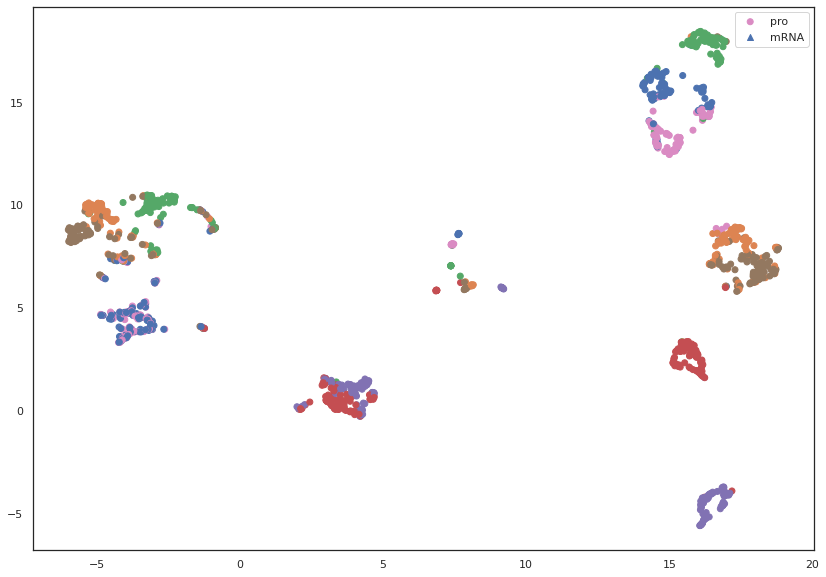

In [9]:
result_df = pro_result_df.dropna()
upam_draw(result_df)

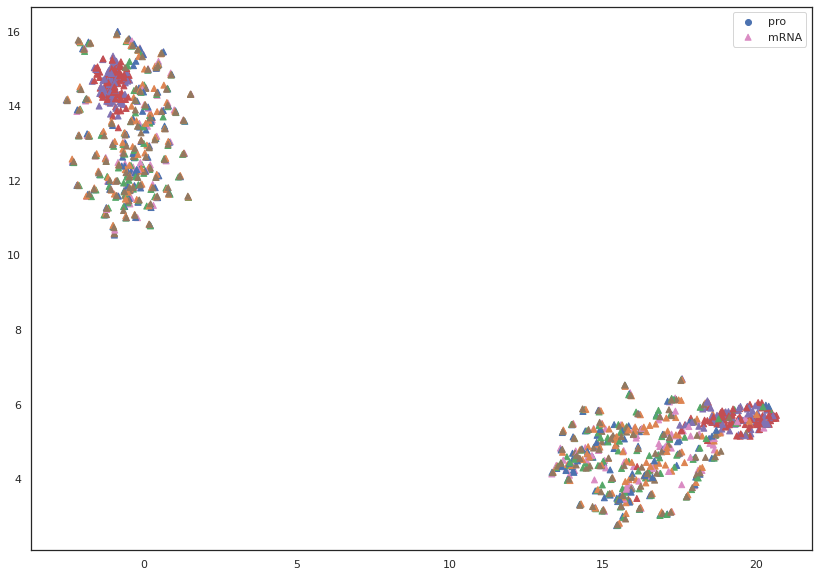

In [10]:
result_df = mRNA_result_df.dropna()
upam_draw(result_df)

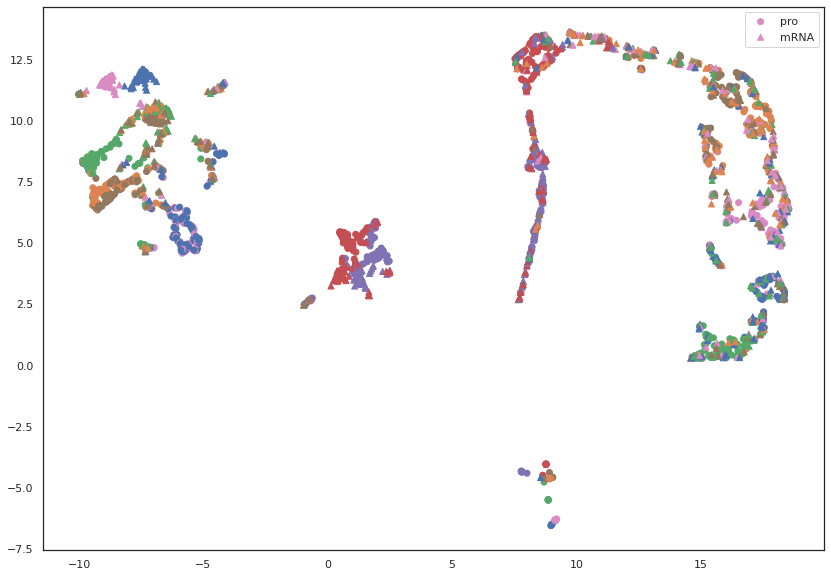

In [11]:
result_df = pro_result_df.merge(mRNA_result_df, how='outer', left_index=True, right_index=True)
result_df = result_df.dropna()
upam_draw(result_df)

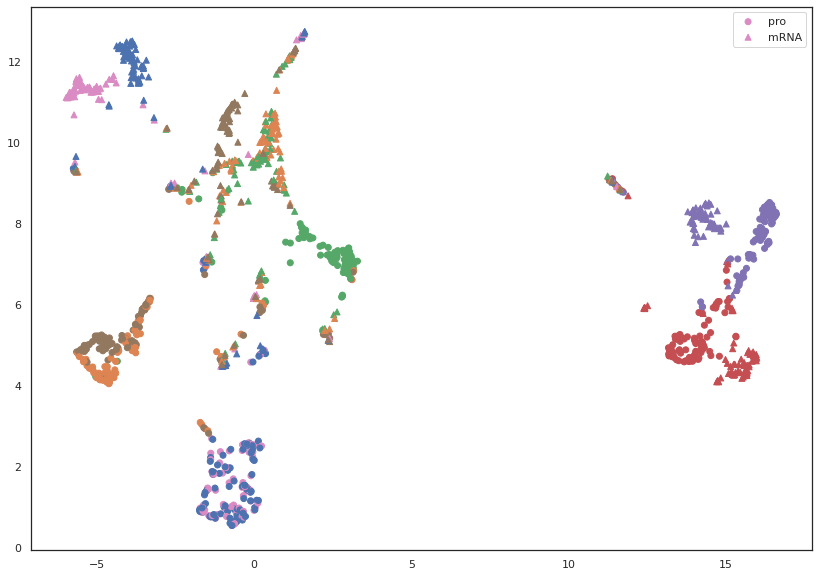

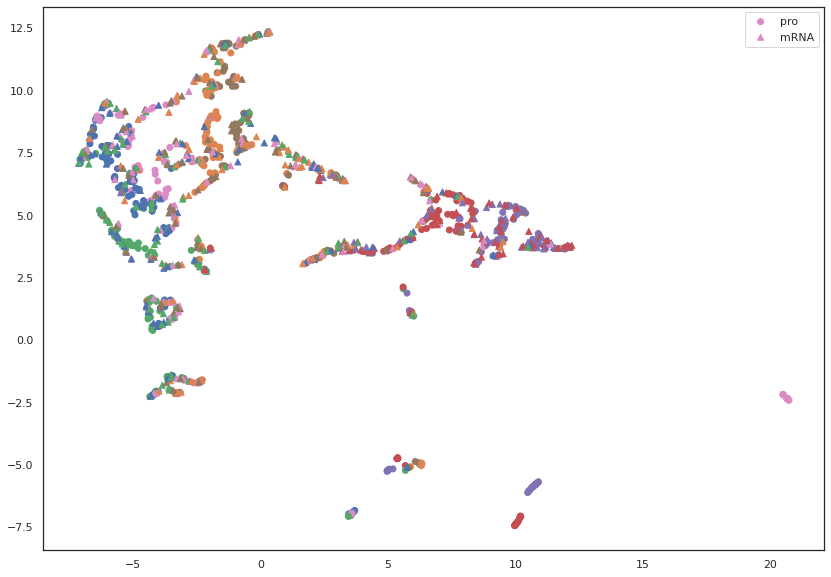

In [12]:
result_df = pro_result_df.merge(mRNA_result_df, how='outer', left_index=True, right_index=True)
result_df = result_df.dropna()
result_df_max = result_df[[i for i in result_df.columns if 'max' in i]]
result_df_min = result_df[[i for i in result_df.columns if 'min' in i]]
upam_draw(result_df_max)

upam_draw(result_df_min)


In [13]:
def combine_min_max(df):
    df_max = df[[i for i in df.columns if 'max' in i]]
    df_min = df[[i for i in df.columns if 'min' in i]]

    df_max.columns = [col.replace('_maximum','') for col in df_max.columns]
    df_min.columns = [col.replace('_minimum','') for col in df_min.columns]
    
    df_min_max = df_max.append(df_min)
    print(df.shape,df_max.shape,df_min.shape,df_min_max.shape)
    return df_min_max

(4828, 1396) (4828, 698) (4828, 698) (9656, 698)
(4828, 1274) (4828, 637) (4828, 637) (9656, 637)
(19312, 1335)
(19312, 1295)


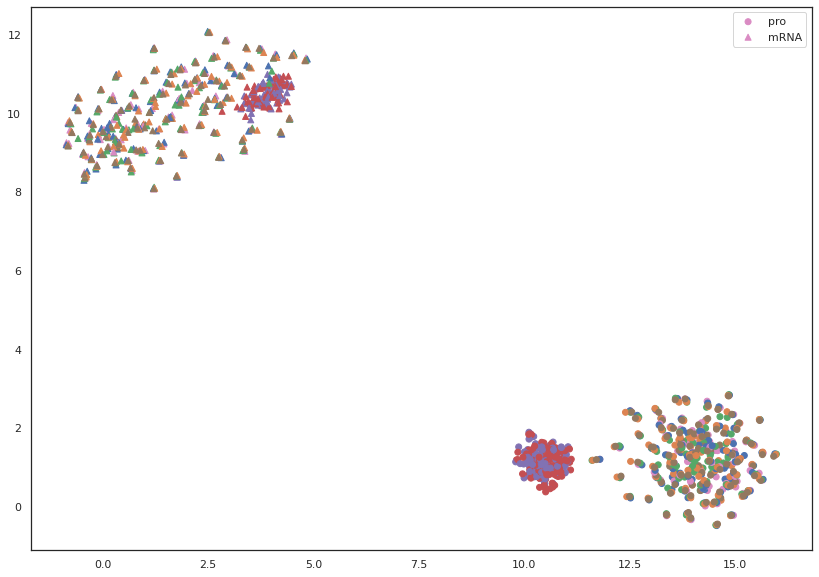

In [14]:
dfpro = combine_min_max(pro_result_df)
dfrna = combine_min_max(mRNA_result_df)

result_df = dfpro.merge(dfrna, how='outer', left_index=True, right_index=True)

print(result_df.shape)
result_df = result_df.dropna(axis=1)
print(result_df.shape)
#result_df_max = result_df[[i for i in result_df.columns if 'max' in i]]
#result_df_min = result_df[[i for i in result_df.columns if 'min' in i]]

#result_df_max.columns = [col.replace('_maximum','') for col in result_df_max.columns]
#result_df_min.columns = [col.replace('_minimum','') for col in result_df_min.columns]

#result_min_max = result_df_max.append(result_df_min)
#print(result_min_max.shape)
upam_draw(result_df)

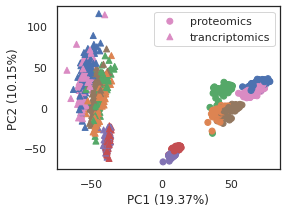

In [51]:
pca_draw(result_df)

In [21]:
dfprot_growth = pd.read_csv('../Results/FVA_result_df_pro_1204_growth.tsv',index_col=0,sep='\t')
dfmrna_growth = pd.read_csv('../Results/FVA_result_df_mRNA_1204_growth.tsv',index_col=0,sep='\t')

In [22]:
dfprot_growth.head()

,growth
0_NACL60,0.128866
0_NACL20,0.020107
0_NACL100,0.036482
0_HN,0.143729
0_Fermentation-9h,0.123126


In [43]:
def plot_growth(dfprot_growth,dfmrna_growth):
    def _load_growth_on_conditions(df):
        gs = {}
        for ind in df.index:
            cond = ind.split('_')[1]
            gs[cond] = gs.get(cond,[]) + [np.max([0,df.loc[ind,'growth']])]
        return gs
    
    gs_prot = _load_growth_on_conditions(dfprot_growth)
    gs_mrna = _load_growth_on_conditions(dfmrna_growth)
    
    conds = list(gs_prot.keys())
    conds.sort()
    
    pos = np.arange(len(conds))*3
    
    plt.figure(figsize=(6,3))
    plt.bar(pos,[np.mean(gs_prot[k]) for k in conds],label='proteomics',zorder=0)
    plt.bar(pos+1,[np.mean(gs_mrna[k]) for k in conds],label='transcriptomics',zorder=0)
    
    for i,cond in enumerate(conds):
        x = pos[i]
        plt.scatter([x]*len(gs_prot[cond])+np.random.normal(scale=0.02,size=len(gs_prot[cond])),gs_prot[cond],color='k',alpha=0.5,zorder=1,s=10)
        plt.scatter([x+1]*len(gs_mrna[cond])+np.random.normal(scale=0.02,size=len(gs_mrna[cond])),gs_mrna[cond],color='k',alpha=0.5,zorder=1,s=10)
    
    plt.xticks(pos+0.5,conds,rotation=45,ha='right')
    plt.ylabel('Specific growth rate')
    plt.legend()
    plt.show()
        

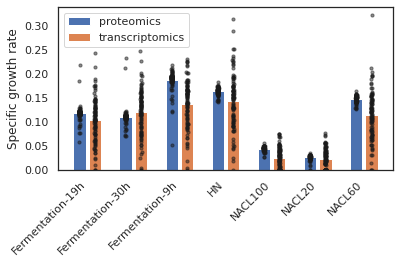

In [44]:
 plot_growth(dfprot_growth,dfmrna_growth)

In [45]:
result_df.head()

,0_NACL60_pro,0_NACL20_pro,0_NACL100_pro,0_HN_pro,0_Fermentation-9h_pro,0_Fermentation-19h_pro,0_Fermentation-30h_pro,1_NACL60_pro,1_NACL20_pro,1_NACL100_pro,...,98_Fermentation-9h_mRNA,98_Fermentation-19h_mRNA,98_Fermentation-30h_mRNA,99_NACL60_mRNA,99_NACL20_mRNA,99_NACL100_mRNA,99_HN_mRNA,99_Fermentation-9h_mRNA,99_Fermentation-19h_mRNA,99_Fermentation-30h_mRNA
1.1.1.136-RXNNo1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.1.1.136-RXNNo1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.1.1.136-RXNNo1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.1.1.136-RXNNo1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.1.1.178-RXNNo1,10.569658,5.459486,3.726108,12.246555,9.082191,9.29363,9.880963,5.841313,3.01718,2.059231,...,11.545579,11.986907,17.713894,1.615939,0.262195,0.334228,1.335128,0.678105,0.704025,1.040388
